# EP3 - Agulha de Buffon Paralelizada

## Preâmbulo e considerações iniciais

Neste Notebook, irei fazer uma análise comparativa entre a minha implementação sequencial e a paralelizada da resolução do problema da Agulha de Buffon. Na parte 1, encontramos o mesmo código serial e discussão utilizados no EP1. Na parte 2, implementamos a paralelização e comparamos os modelos.

A implementação paralelizada fará o uso do OpenMP, pois este é o método do grupo que estou inserido. O OpenMP possui suporte nativo apenas para C, C++ e Fortran, então a implementação paralelizada, idealmente, seria feita em C++. No entanto, essa implementação já foi feita para a apresentação em grupo, então senti que seria apenas uma cópia do que já foi feito. Como me falta prática em C e Fortran, utilizar essas linguagens seria inviável. Para resolver a situação, decidi me manter no Python, pois a biblioteca Numba permite implementação do OpenMP. Considerando que este EP é, além de tudo, um estudo sobre paralelização e não unicamente sobre o OpenMP creio que essa aplicação, apesar de não ideal, ainda será válida e produtiva.

# Parte 1: Código Serial

## Seção 1: Simulação da Agulha de Buffon

Vamos discutir o script utilizado na estimativa de $\pi$ por meio do método de Monte Carlo usando as agulhas de Buffon. No E-Disciplinas, foi incluso o arquivo `buffon.py` que contém este mesmo código, mas feito de tal forma que possa ser executado por si só. Ele possui comentários, também. Para utilizá-lo, basta executá-lo em sua máquina, inputar o número de iterações, e o script irá imprimir o valor estimado de $\pi$, o erro da simulação e o erro real, comparado com o valor do pacote `numpy` do Python. Esse código não possui semente fixa, mas isso pode ser mudado removendo o comentário de uma linha indicada.

Sobre a matemática da agulha de Buffon, podemos calcular a probabilidade $p$ analiticamente por meio da seguinte identidade:

$$p = \frac{2}{\pi}\frac{l}{L}$$

Onde $L$ é a distância entre as duas retas verticais e $l$ é o comprimento da agulha. Se fixarmos $L = 2l$, podemos rearranjar para calcular $\pi$ da seguinte forma:

$$\pi = \frac{1}{p}$$

Daí, podemos estimar $p$ simulando o lançamento da agulha e contanto quantas vezes há um acerto, isto é, quando a agulha cruza uma reta vertical. Daí, podemos calcular:

$$p \approx \frac{N_{\text{acertos}}}{N}$$

Então podemos partir para a simulação em si.

Primeiramente, vamos pegar algumas operações básicas do pacote `numpy` que serão utilizadas no código, incluindo o valor de $\pi$ e as funções para gerar números aleatórios.

In [1]:
from numpy.random import rand
from numpy.random import seed as set_seed
from numpy import pi, sqrt, cos

Agora definimos a classe `Agulha`. Ela possui as propriedades teóricas da agulha, sendo elas a posição horizontal do centro da agulha $x$, o ângulo com a horizontal $\theta$ e o comprimento da agulha $l$ - que tem valor padrão 1. Como no enunciado o plano é infinito, não faz diferença a posição vertical $y$. Além disso, o código suporta diferentes valores para $l$, apesar de não ser necessário para o EP.

Além disso, essa classe possui o método `checar`, que verifica se a agulha está atravessando uma das retas verticais ou não. Apesar do problema original levar em consideração um plano infinito com infinitas retas verticais paralelas, não precisamos considerar todo esse espaço; basta levar em consideração o espaço entre duas retas, uma de $x = 0$ e outra em $x= 2l$. O motivo para isso é simples: não faz diferença, em termos probabilísticos, exatamente onde no plano a agulha cai, mas sim a distância relativa entre ela e as retas verticais mais próximas. Então, podemos considerar um espaço finito, e o mais simples é considerar o espaço entre duas retas paralelas.

Daí entra o método `checar`: ele calcula a *"largura horizontal"* $s = \frac{l\cos(\theta)}{2}$ da agulha, depois verifica qual das duas retas é a mais próxima e determina a distância até ela, $b$, e então compara as duas distâncias. Se $s \geq b$, então a agulha cruza uma das retas. Caso contrário, ela não cruza.

Depois, foram definidas duas funções auxiliares, `jogada` e `calcula_pi`. A primeira função é bem simples, ela apenas gera uma agulha aleatória de $x \in [0, 2l)$ e $\theta \in [0, \frac{\pi}{2})$, com um $l$ de input, mas ele também tem um valor padrão de 1. O motivo de ser aberto é devido à definição da função `rand`, que tem intervalo fixo de $[0, 1)$.

Já a segunda função é mais complexa. Ela recebe o número de iterações desejadas $N$ e realiza um loop de $N$ iterações. Em cada iteração, ela gera uma agulha aleatória e, chamando o método `checar`, checa se ela cruza uma das retas verticais. Se sim, ela incrementa o número de acertos. No final, ela retorna o valor estimado de $\pi$, `pi_buffon`, o erro da simulação `sigma` e, comparando com o valor de $\pi$ do pacote `numpy`, calcula o erro real.

Para facilitar no processo de análise, precisamos garantir reprodutibilidade. Para tanto, a função `calcula_pi` possui outra entrada, o parâmetro `seed`, ou semente. Ele garante que os valores sempre serão os mesmos ao executar o programa com um dado $N$. Fixamos a semente como 1 por padrão, mas isso é arbitrário e pode ser mudado.

In [76]:
class Agulha:

    '''
    Aqui definimos as propriedades básicas da agulha: x, theta e l. Bem auto-explicativo, mas é relevante comentar que l possui um valor padrão de 1.
    '''

    def __init__(self, x, theta, l = 1):
        self.x = x
        self.theta = theta
        self.l = l

    '''
    Depois, definimos a função de checagem.
    '''

    def checar(self):

        # Primeiro extraímos as propriedades do objeto agulha:

        l = self.l
        theta = self.theta
        x = self.x

        # Depois calculamos L = 2l e fazemos a distância horizonal s.

        L = 2*l
        s = (l*cos(theta))/2

        '''
        Como as posições das retas sempre são x = 0 e x = L, podemos calcular
        a distância até elas fazendo L-x e x-0, mas só precisamos do menor, 
        então usamos a função min().
        '''

        b = min(x, L-x)

        # Finalmente checamos se cruza ou não

        if s >= b: 
            return True
        
        else:
            return False

"""
Aqui definimos a função que gera uma agulha aleatória.
Como a função rand() gera um número aleatório entre zero
e um, basta mutliplicarmos pelo limite que queremos para 
obter um valor aleatório no intervalo desejado.
"""

def jogada(l = 1):
    L = 2*l
    return Agulha(x = rand()*L, theta = rand()*(pi/2), l=l)


"""
Finalmente, definimos a função de cálculo de pi.
"""

def calcula_pi(N, seed = 1):
    N_acertos = 0
    
    set_seed(seed) # Aqui fixamos a seed inicial para o restante das jogadas aleatórias.

    for _ in range(N):
        agulha = jogada() # Jogamos uma agulha aleatória...

        if agulha.checar(): # Checamos se ela "acertou"...
            N_acertos += 1  # E, se sim, somamos ao número total de acertos.

    p = N_acertos/N # Finalmente, estimamos a probabilidade com a razão simples.

    pi_buffon = 1/p # Utilizamos ela para estimar pi.

    sigma = p/sqrt(N) # Depois usamos a definição dada em sala para calcular o erro da simulação.

    erro = abs(pi_buffon - pi) # E comparamos com o valor de pi do pacote numpy para determinar o erro real.

    return pi_buffon, sigma, erro # Finalmente, retornamos todos os valores em uma tupla.


Com o código finalizado, podemos passar para uma análise.

## Seção 2: Análise

### Preâmbulo

Para realizarmos a análise, vamos precisar de alguns pacotes a mais:

In [8]:
import numpy as np 
import timeit # Será usado para contar o tempo de execução.
import pandas as pd # Será usado para exportar os dados em .csv.

Agora, vamos definir alguns números de iterações para a análise. Após alguns testes, percebemos que a maior ordem de grandeza viável computacionalmente é $10^9$, que demorou em torno de 40 minutos. Acima disso, em $10^{10}$ por exemplo, demoraria mais de uma hora. Então, criamos a array `N_pot`, com as potências de 10 indo de 1 a 9:

In [77]:
N_pot = np.power(10,np.arange(1,10,1))
N_pot

array([        10,        100,       1000,      10000,     100000,
          1000000,   10000000,  100000000, 1000000000], dtype=int32)

Antes de começarmos os testes, precisamos mudar uma configuração do pacote `timeit`. A questão é que queremos, ao mesmo tempo, rodar a simulação extraindo os resultados e extrair o tempo de execução. Mas, a função `timeit.timeit()` não retorna os valores retornados pelo código que está testando por padrão, então precisamos mudar essa configuração, que pode ser feita com o seguinte código:

In [38]:
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

Agora, basta montarmos um loop simples para iterar em cada valor de $N$ e extrair os resultados da simulação junto ao tempo de execução.

**[Nota: Não é necessário executar esta célula! Salvamos em .csv e vamos usar os dados salvos.]**

In [ ]:
resultados = []
for N in N_pot:
    resultados.append(
        timeit.timeit(
            'calcula_pi(N)',
            globals= globals(),
            number = 1))

Pronto. No entanto, a lista `resultados` tem como elementos tuplas, sendo elas estruturadas da seguinte maneira:

```python
(tempo, (pi_buffon, sigma, erro))
```

Então, será mais prático separá-las em duas listas, sendo elas `tempos` e `valores`:

In [ ]:
tempos = []
valores = []

for elemento in resultados:
    tempos.append(elemento[0])
    valores.append(elemento[1])

Agora, salvamos esses valores para não precisarmos executar o código novamente. Para isso, usamos o pacote `pandas`:

In [ ]:
pd.DataFrame(valores).to_csv('Valores')
pd.DataFrame(tempos).to_csv('Tempos')

Então, assumindo que já fizemos a simulação e salvamos os dados, vamos carregar os dados e transformá-los em uma array.

In [78]:
valores = pd.read_csv('Valores', index_col = 0)
tempos = pd.read_csv('Tempos', index_col = 0)

In [79]:
valores, tempos = np.array(valores), np.array(tempos['0'])

### Análise e Visualizações

#### Análise dos erros

Agora com os dados agregados, podemos iniciar uma análise para responder as perguntas propostas. Primeiro, vamos à análise dos erros. Para tanto, vamos preparar um gráfico.

In [83]:
import matplotlib.pyplot as plt

Podemos organizar um gráfico legível colocando os valores de $N$ em $\log_{10}$.

Text(0, 0.5, 'Erro')

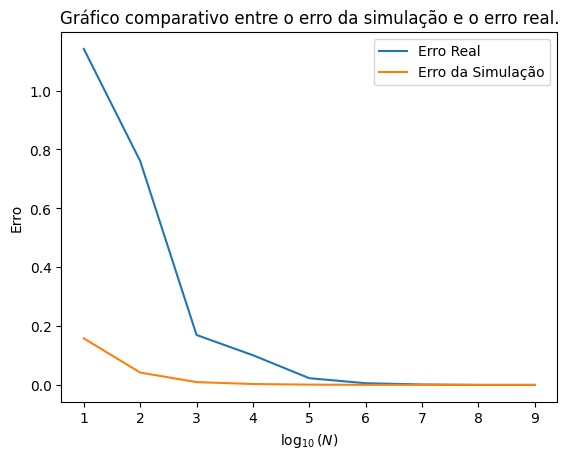

In [90]:
plt.plot(np.log10(N_pot), np.array(valores)[:,2],label='Erro Real')
plt.plot(np.log10(N_pot), np.array(valores)[:,1],label='Erro da Simulação')
plt.title('Gráfico comparativo entre o erro da simulação e o erro real.')
plt.legend()
plt.xlabel(r'$\log_{10}(N)$')
plt.ylabel('Erro')

Ao analisarmos o gráfico, podemos perceber que ambos os erros tendem a convergir no zero, o que é esperado. Além disso, o erro real tende a convergir mais rápido que o erro da simulação, mas ao mesmo tempo começa num valor muito mais divergente que o erro da simulação. Isso é esperado, pois a simulação é muito ineficiente para calcular $\pi$, então se espera uma variação inicial maior para o erro real e menos para o erro da simulação, já que este é apenas uma medida estatística. Como o erro da simulação é menor, isso indica que ela é precisa, apesar da convergência lenta.

#### Análise do tempo de execução

Agora, queremos estimar quanto tempo demorará para conseguir uma precisão de 14 dígitos. Para isso, queremos que o erro da simulação seja da ordem de $10^{-15}$. Então, vamos fazer alguns ajustes com ajuda do pacote `scipy.optimize`.

In [20]:
import scipy.optimize as scp

Primeiro, vamos ver o gráfico do tempo de execução em função de $N$.

Text(0, 0.5, 'Tempo (s)')

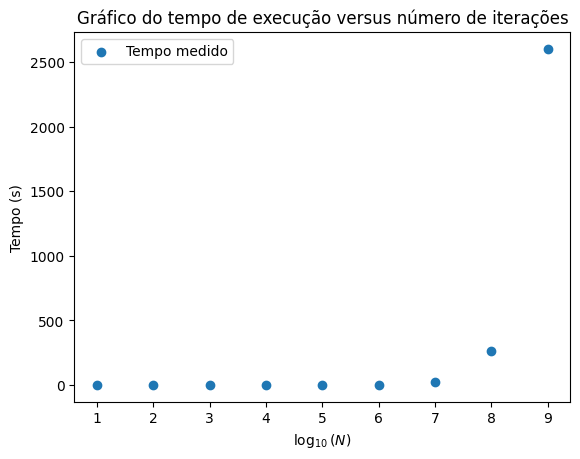

In [104]:
plt.scatter(np.log10(N_pot), tempos,label=r'Tempo medido')
plt.legend()
plt.title('Gráfico do tempo de execução versus número de iterações')
plt.xlabel(r'$\log_{10}(N)$')
plt.ylabel(r'Tempo (s)')

Observamos uma variação brusca no tempo de execução que sugere uma relação exponencial. Se é o caso, sendo o tempo de execução $t$ e o número de iterações $N$, podemos escrever:

$$t = b\cdot N^a$$

Sendo $a$ e $b$ parâmetros a descobrir. Se isso é o caso, podemos escrever:

$$\log(t) = a\log(N) + \log(b)$$

Então, podemos realizar um ajuste linear. Vamos fazê-lo:

In [105]:
func = lambda x, a, b: a*x + b # Função linear de ajuste.

In [44]:
fit, cov = scp.curve_fit(func, np.log10(N_pot),np.log10(tempos))

In [45]:
x_space = np.linspace(0, np.log10(N_pot)[-1], 1000)

Com isso podemos plotar:

Text(0, 0.5, 'Tempo ($log_{10}(s)$)')

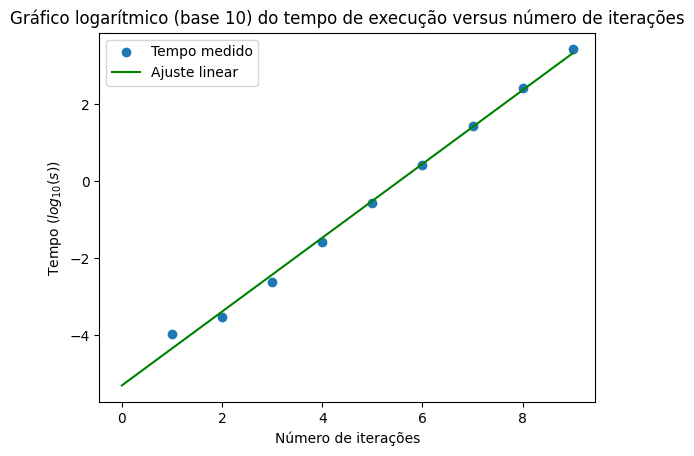

In [101]:
plt.scatter(np.log10(N_pot), np.log10(tempos),label=r'Tempo medido')
plt.plot(x_space, func(x_space,fit[0], fit[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do tempo de execução versus número de iterações')
plt.xlabel('Número de iterações')
plt.ylabel(r'Tempo ($log_{10}(s)$)')

Como podemos ver, o gráfico é linear, então nossa suposição de usar um modelo exponencial era válida. Agora, fazemos o mesmo para o erro, que também deve ser exponencial - isso é feito pelo mesmo argumento, não repetiremos por brevidade.

In [106]:
fit1, cov1 = scp.curve_fit(func, np.log10(N_pot),np.log10(np.array(valores)[:,2]))

In [107]:
fit1

array([-0.56141884,  0.95597189])

Text(0.5, 0, 'Número de iterações')

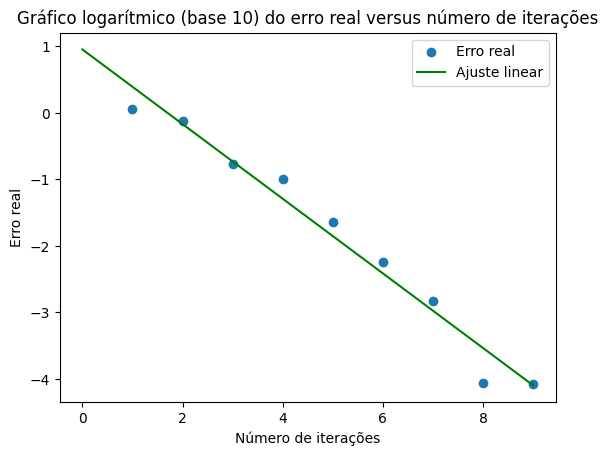

In [108]:
plt.scatter(np.log10(N_pot), np.log10(np.array(valores)[:,2]),label='Erro real')
plt.plot(x_space, func(x_space,fit1[0],fit1[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do erro real versus número de iterações')
plt.ylabel('Erro real')
plt.xlabel('Número de iterações')


Como podemos ver, o erro também é exponencial e cai com o número de iterações. Então, queremos que o erro seja da ordem de $10^{-15}$, então podemos calcular o número de iterações necessário para isso:

In [115]:
N_alvo = 10**((-15 - fit1[1])/fit1[0])
N_alvo

2.6351099537763767e+28

Então, precisamos de $~2.63\cdot 10^{28}$ iterações. Utilizando ele na função exponencial, temos:

In [116]:
tempo_total = (10**fit[1])*N_alvo**fit[0]
tempo_total

8.145680296419222e+21

Isso é um número absurdo! São $8.14$ sextilhões de segundos! Colocando em perspectiva, vamos comparar com a idade do universo, que é $~13.787$ bilhões de anos:

In [117]:
idade_universo = 13.787*10**9*(365*24*60*6)

In [118]:
tempo_total/idade_universo

187348.82698607628

Ou seja, são $~187$ mil idades do universo! 

# Parte 2: Código Paralelo

## Seção 1: Implementação e discussão

Primeiro, vamos reescrever o código original, mas dessa vez paralelo. Para tanto, vamos utilizar o pacote `numba`, que permite paralelização por OpenMP.

In [15]:
from numba import  config, threading_layer, njit, prange, get_thread_id

Lembrando que, para o uso da camada de threading OpenMP, precisa-se ter instalado uma biblioteca runtime adequada, como a `intel-openmp`, que foi utilizada nessa aplicação. Para utilizarmos a camada OpenMP, precisamos configurar a prioridade das camadas para utilizar primeiro a camada `omp` (por padrão, utiliza-se a camada `tbb`).

In [3]:
config.THREADING_LAYER = 'threadsafe'

config.THREADING_LAYER_PRIORITY = ['omp', 'tbb', 'workqueue']

Pronto. Agora, toda paralelização que aplicarmos será feita com OpenMP. Podemos verificar que isso está ocorrendo por meio do comando `threading_layer()`. Agora, vamos verificar quantos threads temos disponíveis:

In [4]:
config.NUMBA_DEFAULT_NUM_THREADS

12

Na minha máquina, onde executarei o código, tenho 12 threads disponíveis. Então, farei a análise com base nisso. Agora, vamos redefinir as funções para funcionarem de forma paralela. Para diferenciá-las, colocarei um `p` no início de seus nomes.

Porém, a estrutura do código serial anterior, apesar de simples e intuitiva, tornará a paralelização por Numba um tanto mais complicada. Isso se deve pelo fato que o pacote é estruturado com enfoque na paralelização de funções, e não de classes. Apesar de existirem formas de realizar esse tipo de aplicação com Numba (como pelo uso de `@jitclass`), isso se mostra desnecessariamente complexo para essa aplicação. Então, para facilitar a paralelização, vamos reescrever o código serial de forma que ele não use a classe `Agulha`.

In [166]:
'''
Primeiro vou definir a função pchecar, que é efetivamente o método "Agulha.checar()", mas que não depende da classe Agulha. Ele receberá como input
os valores de x e theta, mas como inputs diretos na função, e não tirando-os do objeto Agulha associado.
'''

@njit(parallel=True) # Marcador que indica ao pacote Numba que queremos paralelizar essa função.
def pchecar(x, theta, l = 1):
    L = 2*l

    s = (l*cos(theta))/2

    b = min(x, L-x)

    if s >= b: 
        return True

    else:
        return False
    
'''
Agora, temos uma questão que sempre assola a programação paralela: a geração de números aleatórios. Dependendo de como são organizados, podem levar
a muitos problemas. Para resolver isso, precisamos definir a seed e a função de geração de números aleatórios como funções paralelizadas, que faço a seguir:
'''

@njit # Idem.
def p_set_seed(seed):
    set_seed(seed)

@njit # Idem.
def prand():
    return rand()
    
'''
Finalmente, definimos p_calcula_pi, que é a versão paralelizada de calcula_pi. No lugar de usar a função jogada() para gerar uma agulha aleatória,
usamos diretamente a função rand() do pacote numpy para gerar x e theta, que aplicamos na função pchecar(). O resto é igual.
'''

@njit(parallel=True) # Idem.
def p_calcula_pi(N, seed = 1, l = 1):
    N_acertos = 0

    L = 2*l

    p_set_seed(seed)

    for _ in prange(N): # prange indica que o loop pode e deve ser paralelizado.
    
        x = prand()*L
        theta = prand()*(pi/2)

        resultado = pchecar(x,theta)

        if resultado: 
            N_acertos += 1  

    p = N_acertos/N 

    pi_buffon = 1/p 

    sigma = p/sqrt(N) 

    erro = abs(pi_buffon - pi) 

    return pi_buffon, sigma, erro 

Agora, sobre a compatibilidade do `numba` com as funções utilizadas. A maioria das operações básicas do Python são inteiramente compatíveis com a paralelização automática `@njit` do pacote; além disso, muitas das funções do `numpy` também são. Das funções básicas que usei (`cos`, `sqrt`) todas são compatíveis. Além disso, o sub-pacote `numpy.random` é quase inteiramente compatível com a paralelização `numba`. Isso inclui a função `numpy.random.rand` aqui utilizada e a função de seed. No entanto, ainda é necessário fazer o seeding de uma forma um pouco diferente, como feito acima. Essa é a uma prescrição do pacote Numba.

Essa discussão sobre números aleatórios foi levantada pelo professor Alex durante a apresentação, dado que é um problema muito comum na paralelização com OpenMP em C++, devido às funções de geração de números aleatórios mais comumente utilizadas em C++ não serem compatíveis com a paralelização em OpenMP. Tanto a prescrição do pacote para seeding quanto as especificações de compatibilidade dele podem ser encotradas [neste link](https://numba.readthedocs.io/en/stable/reference/numpysupported.html).

Para verificar se nossa paralelização está correta, há uma função do pacote `numba` que permite um diagnóstico automático, `parallel_diagnostics`. Vamos utilizá-la para verificar se nossa paralelização está correta, a princípio.

In [178]:
pchecar.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function pchecar, 
C:\Users\Marcus\AppData\Local\Temp\ipykernel_15476\3445391114.py (6)  
No source available
------------------------------ After Optimisation ------------------------------
Parallel structure is already optimal.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 


In [179]:
p_calcula_pi.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function p_calcula_pi, 
C:\Users\Marcus\AppData\Local\Temp\ipykernel_15476\3445391114.py (38)  


Parallel loop listing for  Function p_calcula_pi, C:\Users\Marcus\AppData\Local\Temp\ipykernel_15476\3445391114.py (38) 
------------------------------------------------------------------------------------|loop #ID
@njit(parallel=True) # Idem.                                                        | 
def p_calcula_pi(N, seed = 1, l = 1):                                               | 
    N_acertos = 0                                                                   | 
                                                                                    | 
    L = 2*l                                                                         | 
                                                                                    | 
    p_set_seed(seed)                                                                | 
                                         

Pelo resultado "`Paralel structure is already optimal.`", sabemos que está tudo correto. Podemos partir para a análise.

Faremos a mesma análise que fizemos para o código serial, com a adição da Lei de Amdahl.

## Seção 2: Análise

### Preâmbulo

Para a análise, primeiro faremos o mesmo comparativo que fizemos anteriormente. Pularei as explicações, pois são as mesmas que fizemos anteriormente.

In [5]:
import numpy as np 
import timeit # Será usado para contar o tempo de execução.
import pandas as pd # Será usado para exportar os dados em .csv.

In [182]:
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

In [192]:
N_pot = np.power(10,np.arange(1,10,1))

resultados = []
for N in N_pot:
    resultados.append(
        timeit.timeit(
            'p_calcula_pi(N)',
            globals= globals(),
            number = 1))
    
tempos = []
valores = []

for elemento in resultados:
    tempos.append(elemento[0])
    valores.append(elemento[1])

In [193]:
pd.DataFrame(valores).to_csv('pValores')
pd.DataFrame(tempos).to_csv('pTempos')

In [194]:
valores = pd.read_csv('pValores', index_col = 0)
tempos = pd.read_csv('pTempos', index_col = 0)

valores, tempos = np.array(valores), np.array(tempos['0'])

In [195]:
tempos

array([1.49600004e-04, 6.08999981e-05, 8.78999999e-05, 5.25700016e-04,
       8.63600028e-04, 5.70970000e-03, 5.69742000e-02, 3.24951500e-01,
       3.42718330e+00])

In [196]:
valores

array([[5.00000000e+00, 6.32455532e-02, 1.85840735e+00],
       [3.44827586e+00, 2.90000000e-02, 3.06683208e-01],
       [2.88184438e+00, 1.09731035e-02, 2.59748273e-01],
       [3.10559006e+00, 3.22000000e-03, 3.60025915e-02],
       [3.14218382e+00, 1.00639487e-03, 5.91164164e-04],
       [3.14391260e+00, 3.18075000e-04, 2.31994564e-03],
       [3.14130336e+00, 1.00667694e-04, 2.89289128e-04],
       [3.14201726e+00, 3.18266870e-05, 4.24610098e-04],
       [3.14170391e+00, 1.00654860e-05, 1.11255935e-04]])

Podemos ver que os valores para $\pi$ são calculados com uma velocidade muito mais alta! Com 12 threads, obtivemos o valor de $\pi$ para $10^9$ iterações em aproximadamente 3,4 segundos. Vamos fazer um ajuste com esses dados e comparar com o valor serial para encontrar o tempo que demoraria para obter $\pi$ com 14 dígitos de precisão.

### Estimativa para 14 dígitos de precisão

In [ ]:

plt.scatter(np.log10(N_pot), np.log10(tempos),label=r'Tempo medido')
plt.plot(x_space, func(x_space,fit[0], fit[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do tempo de execução versus número de iterações')
plt.xlabel('Número de iterações')
plt.ylabel(r'Tempo ($log_{10}(s)$)')

fit1, cov1 = scp.curve_fit(func, np.log10(N_pot),np.log10(np.array(valores)[:,2]))

plt.scatter(np.log10(N_pot), np.log10(np.array(valores)[:,2]),label='Erro real')
plt.plot(x_space, func(x_space,fit1[0],fit1[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do erro real versus número de iterações')
plt.ylabel('Erro real')
plt.xlabel('Número de iterações')

N_alvo = 10**((-15 - fit1[1])/fit1[0])
N_alvo

tempo_total = (10**fit[1])*N_alvo**fit[0]
tempo_total

In [4]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Erro')

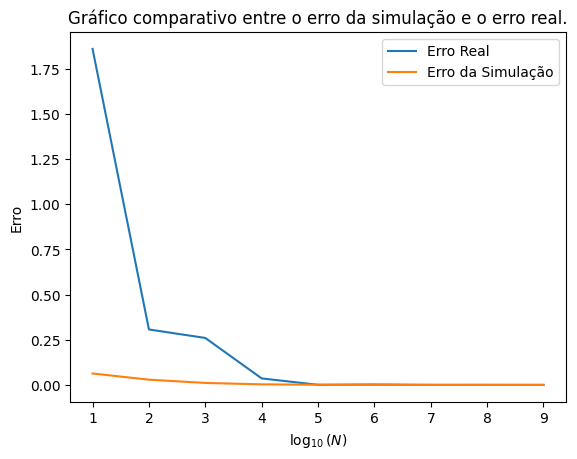

In [199]:
plt.plot(np.log10(N_pot), np.array(valores)[:,2],label='Erro Real')
plt.plot(np.log10(N_pot), np.array(valores)[:,1],label='Erro da Simulação')
plt.title('Gráfico comparativo entre o erro da simulação e o erro real.')
plt.legend()
plt.xlabel(r'$\log_{10}(N)$')
plt.ylabel('Erro')

Primeiro, a análise de erros, que é bem semelhante ao caso serial. Agora, para o ajuste:

In [13]:
import scipy.optimize as scp

Text(0, 0.5, 'Tempo (s)')

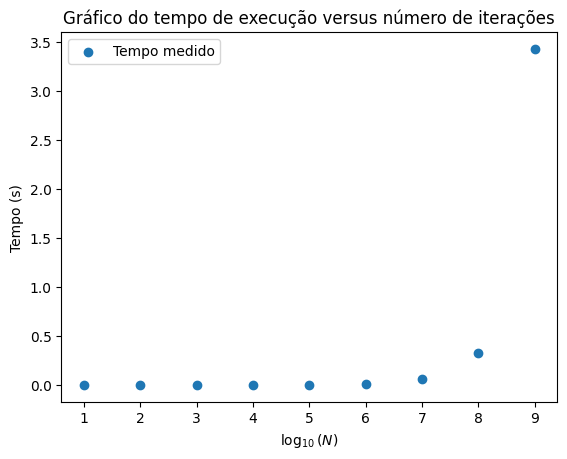

In [201]:
plt.scatter(np.log10(N_pot), tempos,label=r'Tempo medido')
plt.legend()
plt.title('Gráfico do tempo de execução versus número de iterações')
plt.xlabel(r'$\log_{10}(N)$')
plt.ylabel(r'Tempo (s)')

Já vemos uma diferença drástica na ordem de grandeza do tempo de execução, cujo máximo é 3,4 segundos.

In [202]:
func = lambda x, a, b: a*x + b # Função linear de ajuste.

In [203]:
fit, cov = scp.curve_fit(func, np.log10(N_pot),np.log10(tempos))

In [204]:
x_space = np.linspace(0, np.log10(N_pot)[-1], 1000)

Text(0, 0.5, 'Tempo ($log_{10}(s)$)')

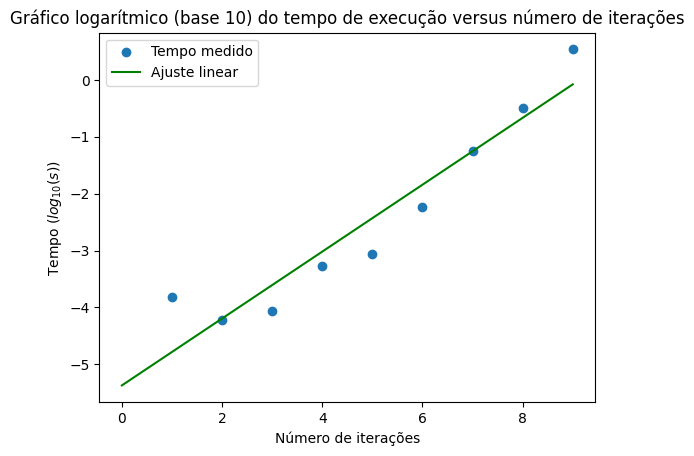

In [206]:
plt.scatter(np.log10(N_pot), np.log10(tempos),label=r'Tempo medido')
plt.plot(x_space, func(x_space,fit[0], fit[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do tempo de execução versus número de iterações')
plt.xlabel('Número de iterações')
plt.ylabel(r'Tempo ($log_{10}(s)$)')

In [207]:
fit1, cov1 = scp.curve_fit(func, np.log10(N_pot),np.log10(np.array(valores)[:,2]))

Text(0.5, 0, 'Número de iterações')

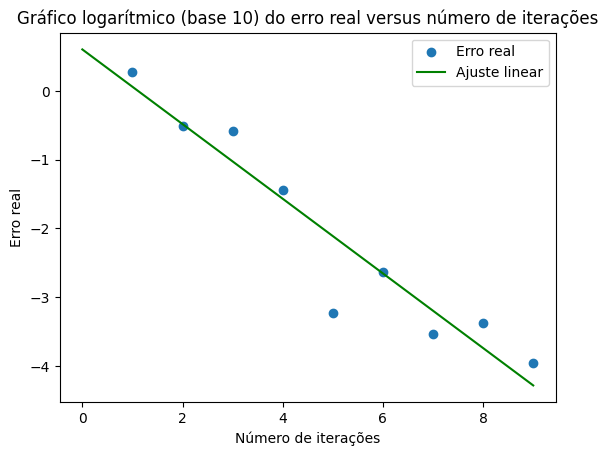

In [208]:
plt.scatter(np.log10(N_pot), np.log10(np.array(valores)[:,2]),label='Erro real')
plt.plot(x_space, func(x_space,fit1[0],fit1[1]), c='green',label='Ajuste linear')
plt.legend()
plt.title('Gráfico logarítmico (base 10) do erro real versus número de iterações')
plt.ylabel('Erro real')
plt.xlabel('Número de iterações')

Nesses últimos dois ajustes, vemos mais variação entre os pontos. Isso é porque o tempo de execução é muito menor, e também o código paralelizado é um pouco mais instável e suscetível a erros numéricos. No entanto, o ajuste ainda é válido.

In [210]:
N_alvo = 10**((-15 - fit1[1])/fit1[0])

tempo_total = (10**fit[1])*N_alvo**fit[0]
tempo_total

340991211614.1224

Ou seja, obtivemos um tempo na ordem de $3\cdot 10^{11}$ segundos, em comparação com o serial, que é da ordem de $8\cdot 10^{21}$ segundos. É uma aceleração de quase 11 ordens de grandeza!

### Lei de Amdahl

Para realizarmos a análise pela Lei de Amdahl, precisamos calcular o tempo de execução com base em um número de threads. Para tanto, escolho um número razoável de iterações, $10^9$, e calculo o tempo de execução para cada número de threads. Aqui, utilizarei apenas de 1 a 12, pois é o máximo de minha máquina. Apesar de pouco quando comparado com uma máquina de HPC, ainda creio ser razoável para um estudo.

Para escolher o número de threads, precisamos importar uma função, `set_num_threads()`.

In [3]:
from numba import set_num_threads

In [214]:
n_threads = np.arange(1,13,1)
n_threads

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [219]:
N = 10**9

In [222]:
resultados = []
for n in n_threads:
    set_num_threads(n)
    resultados.append(
        timeit.timeit(
            'p_calcula_pi(N)',
            globals= globals(),
            number = 1))
    
thread_tempos = []

for elemento in resultados:
    thread_tempos.append(elemento[0])

Vamos salvar e depois recarregar os dados.

In [224]:
pd.DataFrame(thread_tempos).to_csv('Thread_Tempos')

In [14]:
thread_tempos = np.array(pd.read_csv('Thread_Tempos', index_col = 0)).flatten()

In [15]:
thread_tempos

array([23.8342067, 12.5163756,  8.7889647,  6.8907863,  5.762103 ,
        4.9927466,  4.5654531,  4.1243281,  3.8051617,  3.5658019,
        3.3648528,  3.447809 ])

Já podemos verificar algo estranho. Ao passar de 11 para 12 threads, o tempo de execução aumentou, e não diminuiu. Como isso só ocorreu entre essas duas quantias de threads, é possível que seja algo com minha máquina. Então, vou ignorar, apenas removendo esse último item da lista.

In [16]:
thread_tempos = thread_tempos[:-1].copy()
thread_tempos

array([23.8342067, 12.5163756,  8.7889647,  6.8907863,  5.762103 ,
        4.9927466,  4.5654531,  4.1243281,  3.8051617,  3.5658019,
        3.3648528])

Agora, podemos partir para a lei de Amdahl. Ela é dada por:

$$S(n) = \frac{1}{(1-p)+\frac{p}{n}}$$

Onde $S$ é a aceleração (_speedup_) do código em função do número de threads $n$, e $p$ é a porcentagem do tempo de execução do código paralelizável.

Definindo, então a função da lei de Amdahl:

In [17]:
amdahl = lambda n, p: 1/((1-p) + p/n)

Agora, podemos fazer um ajuste para obter $p$. Para tanto, precisamos calcular as acelerações, que são, na prática, só o tempo de execução serial dividido pelo tempo de execução paralelo.

In [18]:
acc = np.array([thread_tempos[0]/thread_tempos[i] for i in range(len(thread_tempos))])

In [19]:
threads = np.arange(1,12,1)

In [20]:
fit, cov = scp.curve_fit(amdahl, threads, acc)

In [21]:
p = fit[0]
p

0.9451114261310639

Obtivemos, então, um $p \approx 94,5\%$. Isso é esperado, afinal, nosso código serial é bem simples e a maior parte do tempo é gasta no loop que itera sobre as $10^9$ iterações. Esse loop, por sua vez, é inteiramente paralelizado graças ao uso do marcador `prange`. Podemos montar um gráfico, então, para visualizar a aceleração.

In [22]:
x_space = np.linspace(0.001, 100, 1000)

Text(0.5, 0, 'Número de threads')

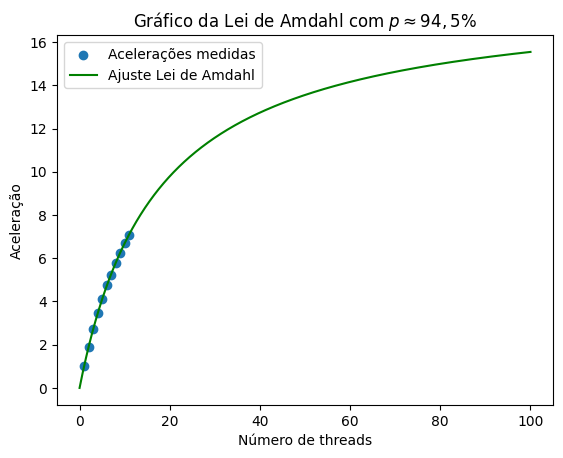

In [23]:
plt.scatter(threads, acc, label='Acelerações medidas')
plt.plot(x_space, amdahl(x_space, fit[0]), c='green',label='Ajuste Lei de Amdahl')
plt.legend()
plt.title(r'Gráfico da Lei de Amdahl com $p \approx 94,5\%$')
plt.ylabel('Aceleração')
plt.xlabel('Número de threads')

Pronto, agora podemos ter uma ideia de qual aceleração obteremos com um número de threads maior. Aqui, escolhi 100, pois já é um número razoavelmente grande para um computador avançado de HPC. Podemos ver que, nesse caso, a aceleração tende a aproximadamente 16, o que é uma aceleração relativamente alta.